# Prepare time-series data from ALOS-2 imagery

Preparing time-series data from ALOS-2 imagery involves several steps to ensure the data is calibrated, filtered, and ready for analysis.

In [2]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopandas

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl (24.1 MB)
Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio import mask
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

## Load the ALOS-2 image

In [3]:
# Load the AOI shapefile (Area of Interest)
aoi = gpd.read_file('/home/jovyan/shared/Sirinya/alos/10.3/AOI_shapefile.shp')

# Paths to the ALOS-2 images
image_paths = [
    '/home/jovyan/shared/Sirinya/alos/10.3/N36E136_18_sl_HH_FP6QAR.tif',
    '/home/jovyan/shared/Sirinya/alos/10.3/N36E136_19_sl_HH_FP6QAR.tif',
    '/home/jovyan/shared/Sirinya/alos/10.3/N36E136_20_sl_HH_FP6QAR.tif',
    '/home/jovyan/shared/Sirinya/alos/10.3/N36E136_2022_sl_HH_FP6QAR.tif'
]

### Function to visualize images
This function, 'visualize_images' displays three images—original, calibrated, and filtered—side by side for comparison. It uses subplots to present each image in grayscale with titles. 

In [4]:
# Function to visualize images
def visualize_images(original, calibrated, filtered, title_prefix=''):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original Clipped Image
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title(f'{title_prefix} Clipped Image')
    axs[0].axis('off')

    # Calibrated Image
    axs[1].imshow(calibrated, cmap='gray')
    axs[1].set_title(f'{title_prefix} Calibrated Image')
    axs[1].axis('off')

    # Filtered Image
    axs[2].imshow(filtered, cmap='gray')
    axs[2].set_title(f'{title_prefix} Filtered Image (Lee Filter)')
    axs[2].axis('off')

    plt.show()

### Lee filter function
This filtering process helps reduce speckle noise commonly found in synthetic aperture radar (SAR) images, improving image quality for further analysis.

In [5]:
# Lee filter function
def lee_filter(image, size=3):
    mean = uniform_filter(image, (size, size))
    mean_sq = uniform_filter(image**2, (size, size))
    variance = mean_sq - mean**2
    
    overall_variance = np.var(image)
    noise_variance = np.maximum(variance - overall_variance, 0)

    weights = noise_variance / (noise_variance + variance)
    filtered_image = mean + weights * (image - mean)
    
    return filtered_image

### Function to process each image

The process_alos_image function processes an ALOS image by performing several steps. Loading and Clipping, Image Processing (clipped image, calibrates, and applies the Lee filter). This function streamlines the preprocessing of ALOS images, making them ready for further analysis or visualization.

In [6]:
# Function to process each image
def process_alos_image(image_path, aoi):
    # Load the image and clip to the AOI
    with rasterio.open(image_path) as src:
        out_image, out_transform = mask.mask(src, aoi.geometry, crop=True)
        out_meta = src.meta.copy()

    # Update metadata for the output image
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    clipped_image = out_image[0]  # Take the first band of the clipped image
    calibrated_image = (20 * np.log10(clipped_image)) - 83
    filtered_image = lee_filter(calibrated_image)

    return clipped_image, calibrated_image, filtered_image, out_meta

## Process all images and visualize original clipped, calibrated, and filtered images

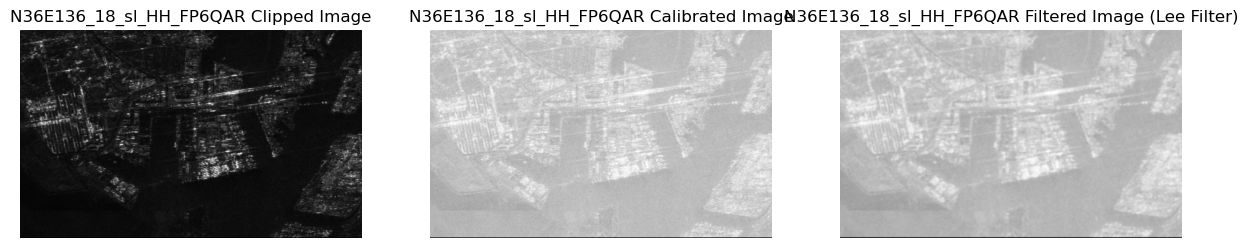

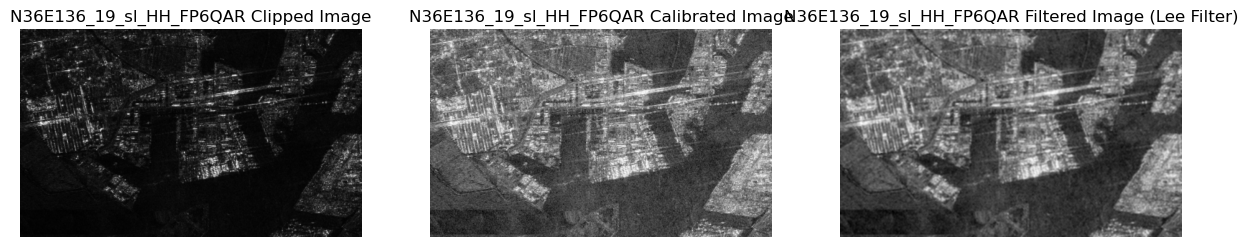

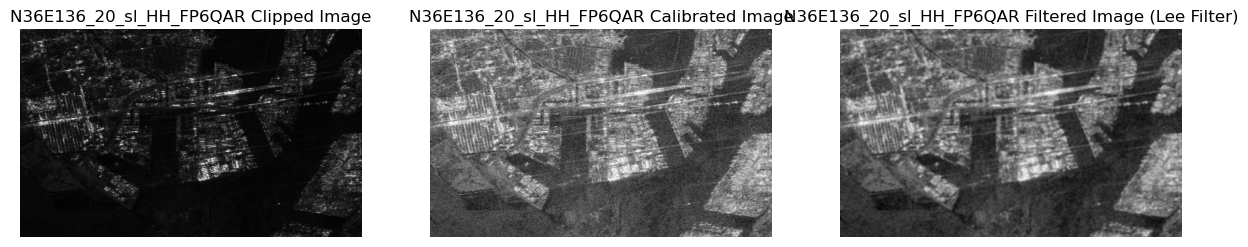

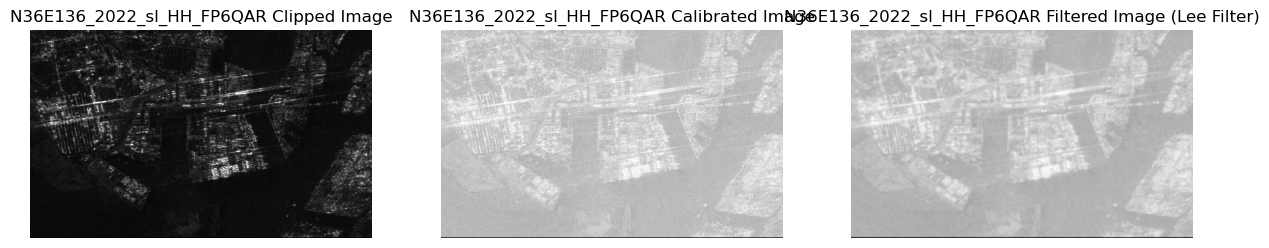

In [7]:
# Process all images and store results
filtered_images = []
meta = None
shapes = []

for image_path in image_paths:
    # Get the file name for visualization title
    file_name = os.path.basename(image_path).split('.')[0]

    # Process the image (clipping, calibration, filtering)
    clipped_image, calibrated_image, filtered_image, image_meta = process_alos_image(image_path, aoi)
    
    # Append filtered image and its shape
    filtered_images.append(filtered_image)
    shapes.append(filtered_image.shape)

    # Store metadata from the first image
    if meta is None:
        meta = image_meta.copy()

    # Visualize the results
    visualize_images(clipped_image, calibrated_image, filtered_image, title_prefix=file_name)

### Stacking and Exporting Function
This code performs resizing of filtered images to a common shape and then stacks them into a single multi-band GeoTIFF.

In [8]:
# Determine the common shape (minimum width and height)
common_shape = (min(s[0] for s in shapes), min(s[1] for s in shapes))

# Function to resize images to a common shape
def resize_image(image, target_shape):
    return resize(image, target_shape, anti_aliasing=True, preserve_range=True)

# Resize all filtered images to the common shape
resized_images = [resize_image(img, common_shape) for img in filtered_images]

# Function to stack the resized images and export as GeoTIFF
def stack_and_export(filtered_images, output_path, meta):
    stacked_image = np.stack(filtered_images, axis=0)

    # Update the metadata for multi-band output
    meta.update({
        "count": len(filtered_images),
        "dtype": 'float32',
        "height": common_shape[0],
        "width": common_shape[1],
    })

    # Write the stacked image to a new GeoTIFF
    with rasterio.open(output_path, 'w', **meta) as dst:
        for i in range(len(filtered_images)):
            dst.write(filtered_images[i], i + 1)

    print(f"Stacked image saved as {output_path}")


## Save the image
This code is responsible for stacking multiple resized images and exporting the result as a GeoTIFF file. 

In [11]:
# Define the output path for the stacked GeoTIFF
output_stacked_image_path = '/home/jovyan/shared/Sirinya/alos/10.3/stacked_filtered_time_series1.tif'

# Stack the resized images and export as GeoTIFF
stack_and_export(resized_images, output_stacked_image_path, meta)

NameError: name 'stack_and_export' is not defined